<a href="https://colab.research.google.com/github/nishantbala/twitter-sentiment-analysis/blob/master/sentiment-analysis-experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Classifier**
### Import the libraries, load dataset, print shape of data, data description

In [ ]:
!pip install contractions
import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

nltk.download('stopwords')                              # Download Stopwords.
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import WhitespaceTokenizer           # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt                         # To plot the figures
import seaborn as sns                                   # To plot the figures
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix

%matplotlib inline

     |████████████████████████████████| 321 kB 7.7 MB/s 
     |████████████████████████████████| 284 kB 42.8 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85446 sha256=dfcce5d34fc66dae7d834faf1f971629297d274267fc7b2f081ae69944dbb0d9
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# load dataset
train = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/train.csv?raw=true')
test = pd.read_csv('https://github.com/nishantbala/twitter-sentiment-analysis/blob/main/input/test.csv?raw=true')

In [ ]:
#print shape

train.shape

(31962, 3)

In [ ]:
#train data first 5 data
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
#train data description
train.describe()

,id,label
count,31962.000000,31962.000000
mean,15981.500000,0.070146
std,9226.778988,0.255397
min,1.000000,0.000000
25%,7991.250000,0.000000
50%,15981.500000,0.000000
75%,23971.750000,0.000000
max,31962.000000,1.000000


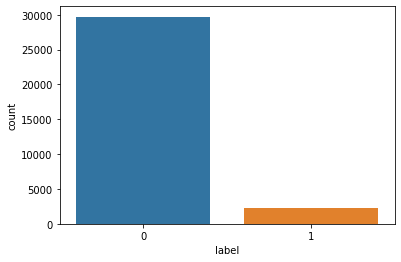

In [ ]:
sns.countplot(x = train['label'])

In [ ]:
train.groupby('label').count()

,id,tweet
label,,
0,29720,29720
1,2242,2242


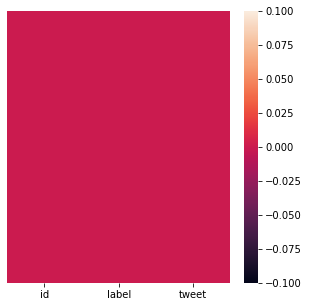

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(train.isnull(), yticklabels=False) # Heatmap for visualising null values

## **Data pre-processing**
### Drop all other columns except “tweet” and “label”

In [ ]:
trimmed_data = train.copy(deep=True)
for col in train.columns:
  if (col != 'tweet' and col != 'label'):
    trimmed_data.drop([col], axis=1, inplace=True)
trimmed_data.shape
trimmed_data.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [ ]:
def top_words(df_tmp, num_top = 20):    
    words = []
    top_words_df = pd.Series([], dtype= 'object') # creating empty data series
        
    for row in df_tmp.iterrows(): # iterating through rows
        words.append(row[1][1].split())
        
    words = list(np.concatenate(words).flat) # list containg all words
    top_words_df = pd.DataFrame(words).value_counts().rename_axis('words')[:num_top].reset_index(name = 'count')
    return top_words_df

In [ ]:
train_data_neutral = trimmed_data.loc[trimmed_data['label'] == 0]
train_data_hate_speech = trimmed_data.loc[trimmed_data['label'] == 1]

In [ ]:
train_data_neutral.head()

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


### Frequent words before pre-processing

In [ ]:
neutral_train_top = top_words(train_data_neutral)
neutral_train_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,@user,15465
1,the,9249
2,to,9207
3,a,5654
4,i,5455
5,you,4555
6,and,4473
7,for,4196
8,in,4147
9,of,3695


In [ ]:
hate_speech_train_top = top_words(train_data_hate_speech)
hate_speech_train_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,@user,1826
1,the,816
2,a,607
3,to,561
4,of,457
5,is,425
6,in,423
7,you,394
8,and,358
9,are,314


In [ ]:
# Remove mentions (twitter handle names eg: @user) from the sentence
def remove_mentions(words):
    return " ".join(filter(lambda x:x[0]!='@', words.split()))

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_mentions(x))
trimmed_data.head()

,label,tweet
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation


### Tokenization of tweets

In [ ]:
Tokenizer=WhitespaceTokenizer()
trimmed_data['tweet'] = trimmed_data.apply(lambda row: Tokenizer.tokenize(row['tweet']), axis=1)
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, can't, use, ca..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, u, take, with, u, all, the, ..."
4,0,"[factsguide:, society, now, #motivation]"


### Replace contractions

In [ ]:
def replace_contractions(text):
    """Replace contractions in string of text"""
    new_words = []
    for word in text:
      new_word = contractions.fix(word)
      if new_word != '':
        new_words.append(new_word)
    return new_words

trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: replace_contractions(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, #lyft, credit, i, cannot, use, b..."
2,0,"[bihday, your, majesty]"
3,0,"[#model, i, love, you, take, with, you, all, t..."
4,0,"[factsguide:, society, now, #motivation]"


### Remove punctuations

In [ ]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_punctuation(x))        

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Convert to lowercase

In [ ]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: to_lowercase(x))

trimmed_data.head()

,label,tweet
0,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,0,"[thanks, for, lyft, credit, i, cannot, use, be..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Stemming

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: lemmatize_list(x))    
trimmed_data.head()

,label,tweet
0,0,"[when, a, father, be, dysfunctional, and, be, ..."
1,0,"[thank, for, lyft, credit, i, cannot, use, bec..."
2,0,"[bihday, your, majesty]"
3,0,"[model, i, love, you, take, with, you, all, th..."
4,0,"[factsguide, society, now, motivation]"


### Remove stop words

In [ ]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(words):
    new_words = []
    for word in words:
      if word not in stop_words:
          new_words.append(word)
    return new_words
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: remove_stopwords(np.array(x)))    
trimmed_data.head()

,label,tweet
0,0,"[father, dysfunctional, selfish, drag, kid, dy..."
1,0,"[thank, lyft, credit, cannot, use, do not, off..."
2,0,"[bihday, majesty]"
3,0,"[model, love, take, time, urð, ðððð, ððð]"
4,0,"[factsguide, society, motivation]"


### Normalize words

In [ ]:
def normalize(words):   
    return ' '.join(words)
trimmed_data['tweet'] = trimmed_data['tweet'].apply(lambda x: normalize(x))
trimmed_data.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cannot use do not offer whee...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society motivation


In [ ]:
trimmed_data_neutral = trimmed_data.loc[trimmed_data['label'] == 0]
trimmed_data_hate_speech = trimmed_data.loc[trimmed_data['label'] == 1]

In [ ]:
trimmed_data_neutral.head()

,label,tweet
0,0,father dysfunctional selfish drag kid dysfunct...
1,0,thank lyft credit cannot use do not offer whee...
2,0,bihday majesty
3,0,model love take time urð ðððð ððð
4,0,factsguide society motivation


In [ ]:
trimmed_data_hate_speech.head()

,label,tweet
13,1,cnn call michigan middle school build wall cha...
14,1,comment australia opkillingbay seashepherd hel...
17,1,retweet agree
23,1,lumpy say prove lumpy
34,1,it is unbelievable 21st century we would need ...


### Frequent words after pre-processing

In [ ]:
neutral_top = top_words(trimmed_data_neutral)
neutral_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,love,2892
1,ð,2465
2,day,2191
3,is,1771
4,get,1719
5,happy,1651
6,â,1595
7,i,1461
8,not,1446
9,go,1344


In [ ]:
hate_speech_top = top_words(trimmed_data_hate_speech)
hate_speech_top.head(10).style.background_gradient(cmap='Reds')

,words,count
0,amp,268
1,trump,210
2,â,202
3,not,182
4,is,161
5,white,152
6,libtard,149
7,black,146
8,like,139
9,racist,102


### Pipeline experimentation

In [ ]:
from sklearn.pipeline import Pipeline

data_for_pipeline = trimmed_data.copy(deep=True)
X_train, X_test, y_train, y_test = train_test_split(data_for_pipeline, labels, test_size=0.3, random_state=42)
steps = [ ('tfidf', TfidfVectorizer()),
          ('randomforestclassifier', RandomForestClassifier())
      ]
pipe = Pipeline(steps)

pipe_fit = pipe.fit(X_train['tweet'],y_train)
print(pipe_fit)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced'))])


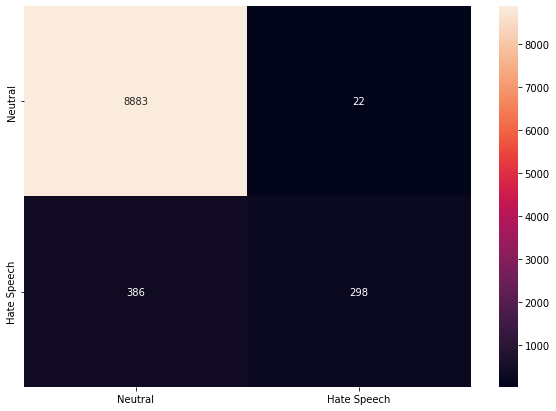

In [ ]:
pipe_result = pipe_fit.predict(X_test['tweet'])

conf_mat = confusion_matrix(y_test, pipe_result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
print(classification_report(y_test, pipe_result))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8905
           1       0.93      0.44      0.59       684

    accuracy                           0.96      9589
   macro avg       0.94      0.72      0.79      9589
weighted avg       0.96      0.96      0.95      9589



### Gridsearch CV

In [ ]:
from sklearn.model_selection import GridSearchCV

data_for_gridsearch = trimmed_data.copy(deep=True)
X_train, X_test, y_train, y_test = train_test_split(data_for_gridsearch, labels, test_size=0.3, random_state=42)

parameters = [{'randomforestclassifier__class_weight': ['balanced']}]
grid_search = GridSearchCV(estimator= pipe,
                          param_grid = parameters, scoring = 'accuracy',cv = 10)
grid_fit = grid_search.fit(X_train['tweet'],y_train)

In [ ]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'randomforestclassifier', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'rando

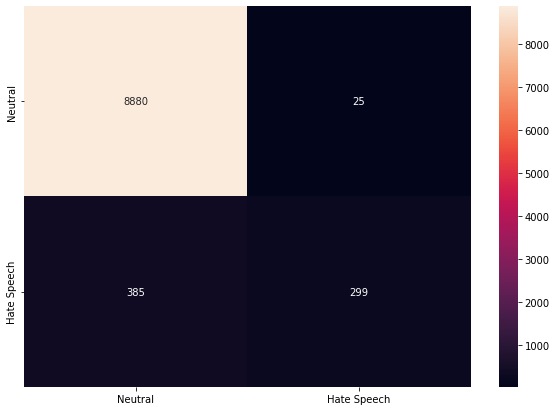

In [ ]:
grid_result = grid_fit.predict(X_test['tweet'])

conf_mat = confusion_matrix(y_test, grid_result)

df_cm = pd.DataFrame(conf_mat, index = [i for i in ["Neutral", "Hate Speech"]],
                  columns = [i for i in ["Neutral", "Hate Speech"]])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

In [ ]:
print(classification_report(y_test, grid_result))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8905
           1       0.92      0.44      0.59       684

    accuracy                           0.96      9589
   macro avg       0.94      0.72      0.79      9589
weighted avg       0.96      0.96      0.95      9589

